In [1]:
import torch
from torch import nn
from d2l import torch as d2l

n_train,n_test,num_inputs,batch_size=20,100,200,5
true_w,true_b=torch.ones((num_inputs,1))*0.01,0.05
train_data=d2l.synthetic_data(true_w,true_b,n_train)
train_iter=d2l.load_array(train_data,batch_size)
test_data=d2l.synthetic_data(true_w,true_b,n_test)
test_iter=d2l.load_array(test_data,batch_size,is_train=False)

In [2]:
def init_params():
    w=torch.normal(0,1,size=(num_inputs,1),requires_grad=True)
    b=torch.zeros(1,requires_grad=True)
    return [w,b]

def l2_penalty(w):
    return torch.sum(w.pow(2))/2

def train(lambd):
    w,b=init_params()
    net,loss=lambda X:d2l.linreg(X,w,b),d2l.squared_loss
    num_epochs,lr=100,0.003
    animator=d2l.Animator(xlabel='epochs',ylabel='loss',yscale='log',xlim=[5,num_epochs],legend=['train','test'])
    for epoch in range(num_epochs):
        for X,y in train_iter:
            l=loss(net(X),y)+lambd*l2_penalty(w)
            l.sum().backward()
            d2l.sgd([w,b],lr,batch_size)
        if(epoch+1)%5==0:
            animator.add(epoch+1,(d2l.evaluate_loss(net,train_iter,loss),d2l.evaluate_loss(net,test_iter,loss)))
    print('L2 norm of w:',torch.norm(w).item())

忽略正则化直接训练

L2 norm of w: 13.599313735961914


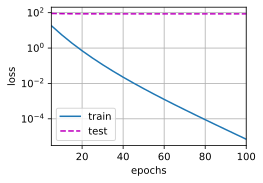

In [3]:
train(lambd=0)

使用权重衰减

L2 norm of w: 0.36662352085113525


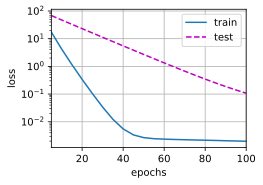

In [4]:
train(lambd=3)

L2 norm of w: 0.021705593913793564


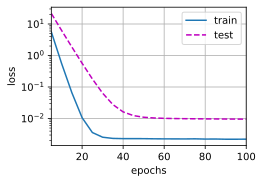

In [26]:
train(lambd=10)

In [8]:
def train_concise(wd):
    net=nn.Sequential(nn.Linear(num_inputs,1))
    for param in net.parameters():
        param.data.normal_()
    loss=nn.MSELoss(reduction='none')
    num_epochs,lr=100,0.003
    trainer=torch.optim.SGD([
        {'params':net[0].weight,'weight_decay':wd},
        {'params':net[0].bias}],lr=lr)  # 偏置参数没有衰减
    animator=d2l.Animator(xlabel='epochs',ylabel='loss',yscale='log',xlim=[5,num_epochs],legend=['train','test'])
    for epoch in range(num_epochs):
        for X,y in train_iter:
            trainer.zero_grad()
            l=loss(net(X),y)
            l.mean().backward()
            trainer.step()
        if(epoch+1)%5==0:
            animator.add(epoch+1,(d2l.evaluate_loss(net,train_iter,loss),d2l.evaluate_loss(net,test_iter,loss)))
    print('L2 norm of w:',net[0].weight.norm().item())

L2 norm of w: 13.171582221984863


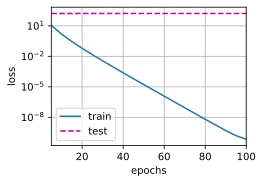

In [9]:
train_concise(0)

L2 norm of w: 0.37121567130088806


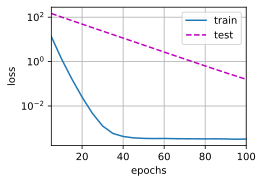

In [10]:
train_concise(3)

Exercises

训练和测试精度与λ的关系

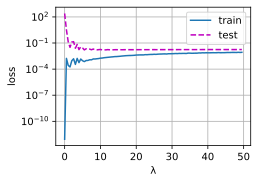

In [22]:
def train_concise_2(wd,num_epochs=500):
    net=nn.Sequential(nn.Linear(num_inputs,1))
    for param in net.parameters():
        param.data.normal_()
    loss=nn.MSELoss(reduction='none')
    trainer=torch.optim.SGD([
        {'params':net[0].weight,'weight_decay':wd},
        {'params':net[0].bias}],lr=0.003)
    for epoch in range(num_epochs):
        for X,y in train_iter:
            trainer.zero_grad()
            l=loss(net(X),y)
            l.mean().backward()
            trainer.step()
    # 返回最终的训练误差、测试误差
    return d2l.evaluate_loss(net,train_iter,loss),d2l.evaluate_loss(net,test_iter,loss)

wds=torch.arange(0,50,0.5)
results=[train_concise_2(wd) for wd in wds]
train_loss,test_loss=zip(*results)
d2l.plot(wds,[train_loss,test_loss],xlabel='λ',ylabel='loss',yscale='log',legend=['train','test'])